# Titanic - Machine Learning from Disaster
* Dataset: https://kaggle.com/c/titanic/data
* Columns:
    * survival: Survival, 0 = No, 1 = Yes
    * pclass: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
    * sex	
    * Age: Age in years	
    * sibsp: # of siblings / spouses aboard the Titanic
    * parch: # of parents / children aboard the Titanic
    * ticket: Ticket number	
    * fare: Passenger fare	
    * cabin: Cabin number	
    * embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("./train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Read CSV test data file into DataFrame
test_df = pd.read_csv("./test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Wrangling

In [5]:
train_data = train_df.copy()

In [6]:
# check missing values in train data
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
def missing_values_percentage(column):
    return round((column.isnull().sum()/train_df.shape[0])*100,2)

### Missing Values

#### Age

In [8]:
# percentage of missing "Age" 
missing_values_percentage(train_df['Age'])

19.87

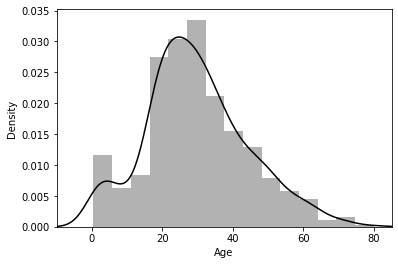

In [9]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='grey', alpha=0.6)
train_df["Age"].plot(kind='density', color='black')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [10]:
# mean age
train_df['Age'].mean(skipna=True)

29.69911764705882

In [11]:
# median age
train_df['Age'].median(skipna=True)

28.0

In [12]:
# use median to fill missing values
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)

#### Cabin

In [13]:
# percentage of missing "Cabin" 
missing_values_percentage(train_df['Cabin'])

77.1

In [14]:
# remove "Cabin" column
train_data.drop('Cabin', axis=1, inplace=True)

#### Embarked

In [15]:
# percentage of missing "Embarked" 
missing_values_percentage(train_df['Embarked'])

0.22

In [16]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

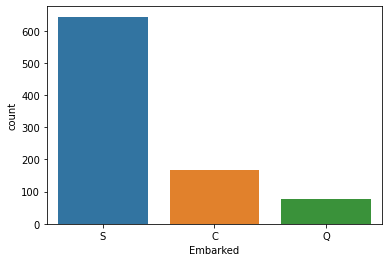

In [17]:
sns.countplot(x='Embarked', data=train_df)
plt.show()

In [18]:
# use the most common boardin port to fill missing values
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)

### Categorical columns

In [19]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [20]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [21]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

In [22]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


### Apply the same changes to test data

In [23]:
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,PassengerId,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,892,34.5,7.8292,1,0,0,1,0,1,0,1
1,893,47.0,7.0000,0,0,0,1,0,0,1,0
2,894,62.0,9.6875,1,0,1,0,0,1,0,1
3,895,27.0,8.6625,1,0,0,1,0,0,1,1
4,896,22.0,12.2875,0,0,0,1,0,0,1,0


## Exploratory Data Analysis

### Exploration of Age

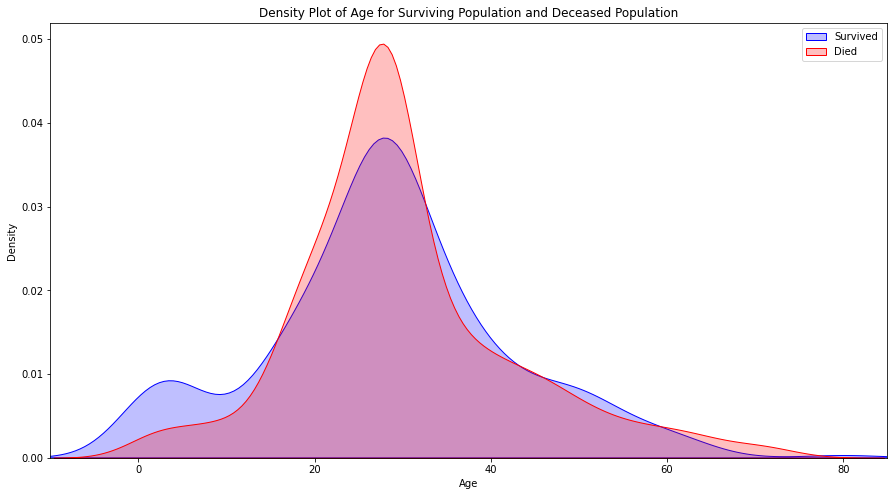

In [24]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="blue", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="red", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

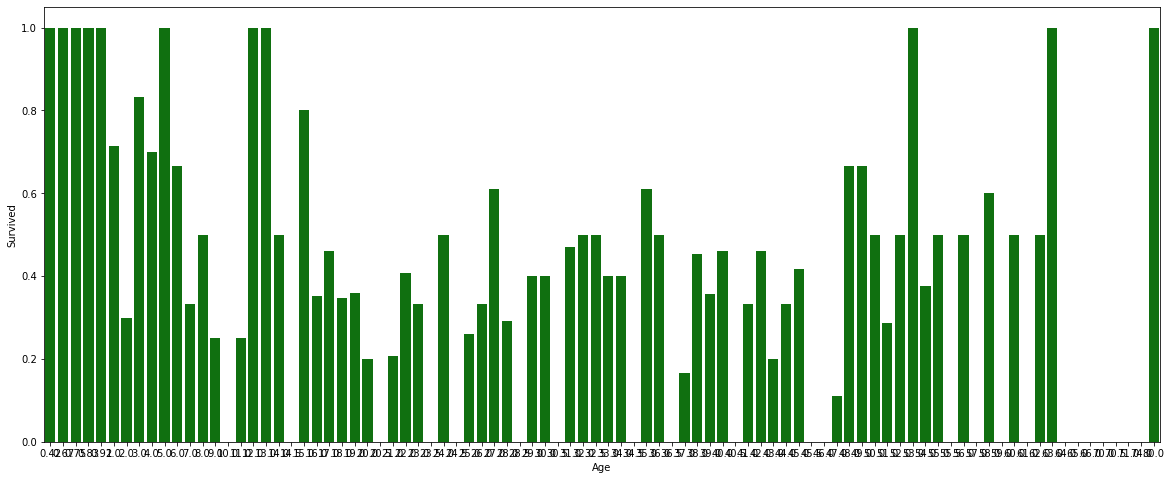

In [25]:
plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="green")
plt.show()

In [26]:
# new column for set if the passenger is under 16
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)
final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

### Exploration of Fare

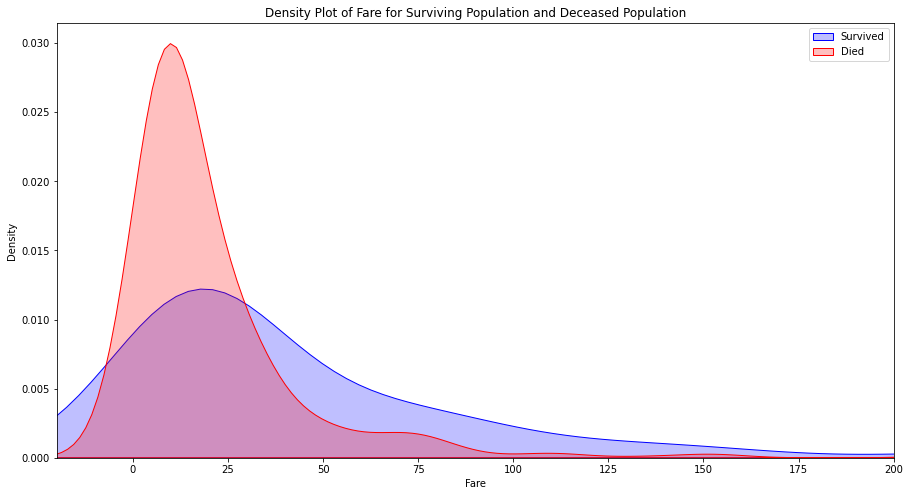

In [27]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="blue", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="red", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

### Exploration of Passenger Class (Pclass)

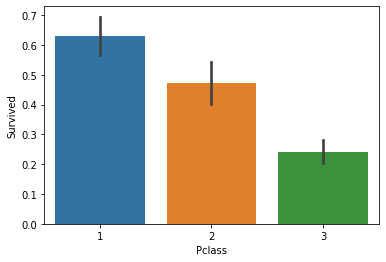

In [28]:
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.show()

### Exploration of Embarked Port

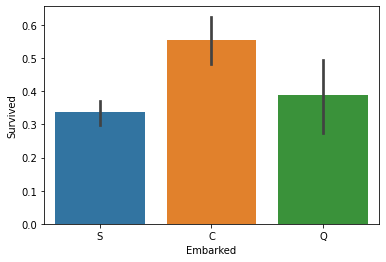

In [29]:
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.show()

### Exploration of Gender Variable

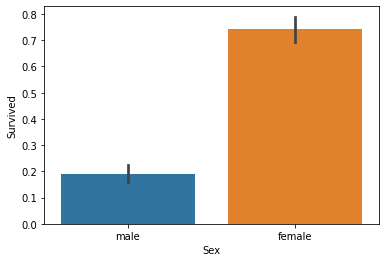

In [30]:
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.show()

## Logistic Regression

In [31]:
features = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"]
x_train = final_train[features]
y_train = final_train['Survived']

### Correlation

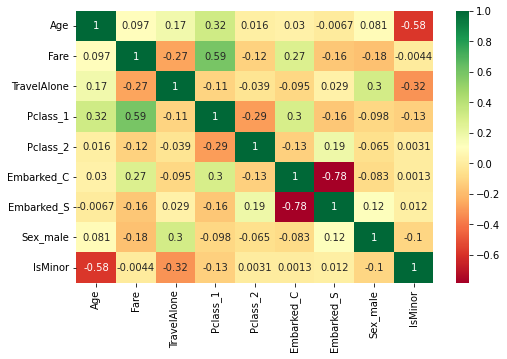

In [32]:
plt.subplots(figsize=(8, 5))
sns.heatmap(x_train.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Build model

In [33]:
# Creating and training the logistic regression model
model = LogisticRegression(max_iter=1000)

In [34]:
rfecv = RFECV(estimator=model, step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

RFECV(cv=10, estimator=LogisticRegression(max_iter=1000), scoring='accuracy')

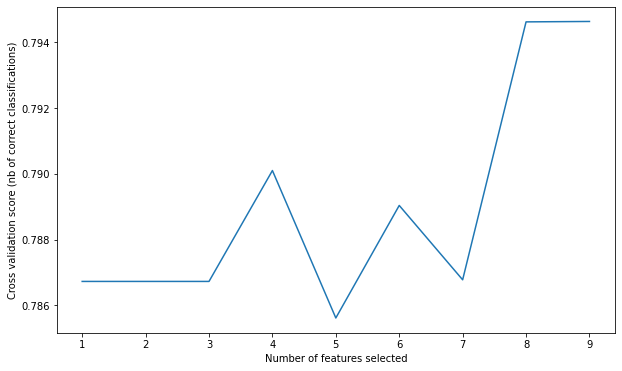

In [35]:
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [36]:
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [37]:
x_test = final_test[features]
final_test['Survived'] = model.predict(x_test)

In [38]:
results = pd.read_csv('./gender_submission.csv')

In [39]:
final_test['PassengerId'].equals(results['PassengerId'])

True

In [40]:
accuracy_score(final_test['Survived'], results['Survived'])

0.9497607655502392

In [41]:
final_test[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)